In [13]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,472 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout


In [2]:
import torch
import torchvision
import torch.nn

In [3]:
torch.cuda.is_available()

True

# 데이터 전처리

In [4]:
#디렉토리에서 이미지 로드하기
from google.colab import drive
drive.mount('/content/drive')

categories = os.listdir('/content/drive/MyDrive/kfood_final')
from matplotlib import font_manager, rc
font_path = "/content/drive/MyDrive/NanumSquareRoundB.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

Mounted at /content/drive


In [5]:
img_size = 256
def get_data(data_dir):
    data = [] 
    for category in categories: 
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) #reshape하기, 깨진 이미지 분류
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)



In [6]:
data = get_data('/content/drive/MyDrive/kfood_final')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [7]:
import random 
np.random.shuffle(data)

In [8]:
#train, test 나누기
train = data[:80]
val = data[80:]
x_train = []
y_train = []
x_val = []
y_val = []

#x에는 feature, y에는 label 넣기
for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [9]:
# 데이터 (픽셀값)정규화하기 (256*256이기 때문에 255로 나누기)
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

#각 이미지의 모양을 256*256 모양으로 변경하기
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

#컨볼루션 신경망 모델(CNN)
마지막 15개의 노드로 최종 분류를 위해 하나의 softmax 레이어를 추가한다


**첫번째 인자**: 컨볼루션 필터의 수 \n


**두번째 인자**: 컨볼루션 커널의 (행, 열)


**padding**: 경계 처리 방법을 정의


> ‘valid’ : 유효한 영역만 출력, 따라서 출력 이미지 사이즈는 입력 사이즈보다 작다.



> ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.


**input_shape**: 샘플 수를 제외한 입력 형태를 정의. 모델에서 첫 레이어일 때만 정의, (행, 열, 채널 수)로 정의. 흑백영상인 경우에는 채널이 1이고, 컬러(RGB)영상인 경우에는 채널을 3으로 설정.


**activation** : 활성화 함수 설정


>‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력
‘relu’ : rectifier 함수, 은닉층에 사용

> ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 사용

> ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 사용 





In [10]:
model = Sequential()
#padding = ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256,activation="relu"))
#음식의 class 수가 6개이므로 6개 노드로 최종분류레이어 설정
model.add(Dense(6, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

#optimizer
모델 파라미터 업데이트 실시 (최적 하이퍼 파라미터 업데이트)

얼마나 진행할지 결정하는 에포크(Epoch), 내부 노드(뉴런) 수, 일정한 데이터를 버려서 오버피팅(Overfitting, 과적합)이 일어나지 않게 하는 드롭아웃(Dropout) 등등 모델을 생성할 때 수많은 파라미터를 조정하게 되는데 그 중에 가장 드라마틱하고 쉽게 바꿔주는 것이 옵티마이저이다.

학습 데이터(Train data)셋을 이용하여 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할

#옵티마이저 종류
*  경사하강법
*  확률적 경사 하강법 (SGD)
*  Momentum
*  Nesterov Accelerated Gradient (NAG)
*  Adam(Adaptive Moment Estimation)
*  AdaGrad
*  RMSProp
*  AdaMax
*  Nadam

In [11]:
#역전파로 모델 파라미터 업데이트 한다.
#200epoch로 모델 훈련한다. 
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)]
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 200, validation_data = (x_val, y_val), callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 18s 2s/step - loss: 1.7956 - accuracy: 0.2750 - val_loss: 1.7978 - val_accuracy: 0.1635
Epoch 2/200
3/3 [==============================] - 2s 776ms/step - loss: 1.7652 - accuracy: 0.2375 - val_loss: 1.8156 - val_accuracy: 0.1635
Epoch 3/200
3/3 [==============================] - 2s 771ms/step - loss: 1.7493 - accuracy: 0.2375 - val_loss: 1.7962 - val_accuracy: 0.1635
Epoch 4/200
3/3 [==============================] - 2s 776ms/step - loss: 1.7188 - accuracy: 0.2375 - val_loss: 1.7843 - val_accuracy: 0.1616
Epoch 5/200
3/3 [==============================] - 2s 776ms/step - loss: 1.6837 - accuracy: 0.2375 - val_loss: 1.7546 - val_accuracy: 0.1730
Epoch 6/200
3/3 [==============================] - 2s 778ms/step - loss: 1.6481 - accuracy: 0.3125 - val_loss: 1.7262 - val_accuracy: 0.1939
Epoch 7/200
3/3 [==============================] - 2s 779ms/step - loss: 1.5817 - accuracy: 0.4250 - val_loss: 1.6783 - val_accuracy: 0.2719
Epoch 8/200
3/3 [==========

findfont: Font family ['NanumSquareRound'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareRound'] not found. Falling back to DejaVu Sans.


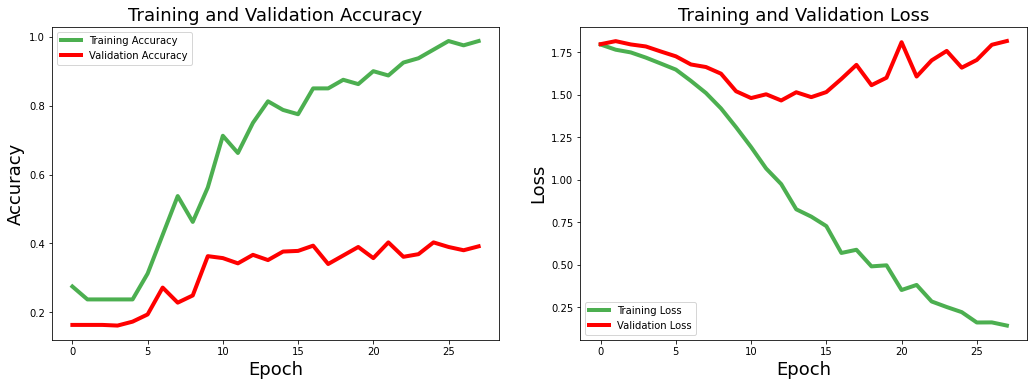

In [12]:
#훈련 및 검증 손실을 플로팅
#에포크에 대한 정확도 점수 분석

epochs_range = range(200)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax1.plot(acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
plt.show()

In [13]:
#score
#훈련 된 CNN 모델을 테스트하고 정밀도, 재현율 및 F1 점수의 형태로 성능을 출력
y_prob = model.predict(x_val) 
predictions = y_prob.argmax(axis=-1)
predictions = predictions.reshape(1,-1)[0]
from sklearn.metrics import classification_report,confusion_matrix
#CNN 모델의 카테고리 별 성능을 보여준다
print(classification_report(y_val, predictions, target_names = categories))

              precision    recall  f1-score   support

  된장찌개       0.29      0.35      0.31        86
   잡곡밥       0.34      0.35      0.34        89
   김치찌개       0.35      0.59      0.44        86
   배추김치       0.51      0.25      0.34        88
    미역국       0.88      0.51      0.64        89
    백김치       0.30      0.31      0.30        88

    accuracy                           0.39       526
   macro avg       0.44      0.39      0.40       526
weighted avg       0.45      0.39      0.40       526



findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4460 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_

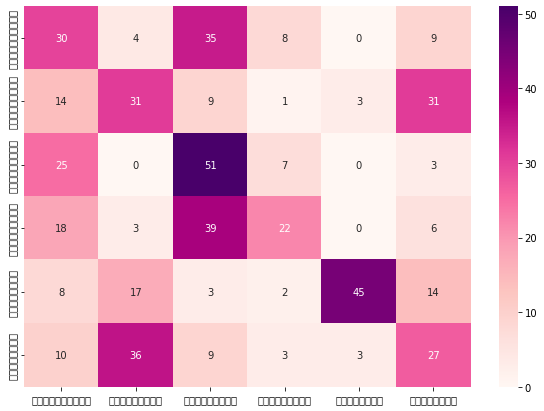

In [14]:
#confusion matrix
#모델의 성능을 표로 만들어서 출력한다. 
#이상적인 혼동 행렬에서 모든 비 대각선 값은 0
#confusion matrix에서 잘못 분류 된 이미지를 분석 할 수 있다
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (10,7))
plt.rc('font', family='NanumBarunGothic')
sn.heatmap(df_cm, annot=True,cmap="RdPu")

#전이학습(TL)
학습 데이터가 부족한 분야의 모델 구축을 위해 데이터가 풍부한 분야에서 훈련된 모델을 재사용하는 학습 기법

**왜 Transfer Learning(전이 학습)을 사용하는가?**

- 이미 학습된 모델을 사용해서 문제를 해결할 수 있습니다.

- 이미 학습된 많은 모델은 적용하려는 데이터가 학습할 때의 데이터와 같은 분포를 가진다고 가정으로 했을 때 효율적입니다.

- 새로운 문제를 해결하려할 때 데이터의 분포가 바뀌면 기존의 통계쩍 모델을 새로운 데이터로 다시 만들어야 할 때 좋습니다.

- 복잡한 모델일 때 학습 시간이 오래 걸릴 수 있으며, 학습시키는데 어려움이 있습니다.

- 층(layer)의 개수, Activation function, Hyper-parameters등 모델을 구성하는데 고려해야할 사항이 많으며, 직접 모델을 구성하여 학습시킨다는 것은 많은 시도가 필요합니다.
 
따라서 이미 잘 훈련된 모델이 있고, 만드려는 모델과 유사한 문제를 해결하는 모델일 경우에는 Transfer Learning(전이 학습)을 사용합니다.

In [16]:
#ImageNet 데이터 세트에서 훈련 된 모델의 사전 훈련 된 가중치를 사용
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")
base_model.trainable = False
#기존 모델 가중치를 다시 훈련하지 않는다. (마지막 레이어만 훈련)
model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dropout(0.2), tf.keras.layers.Dense(20, activation="softmax")])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
__________________________________________

In [17]:
base_learning_rate = 0.0001
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history1 = model.fit(x_train,y_train,epochs = 800 , validation_data = (x_val, y_val), callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 8s 2s/step - loss: 3.3449 - accuracy: 0.0125 - val_loss: 3.2384 - val_accuracy: 0.0646
Epoch 2/800
3/3 [==============================] - 2s 906ms/step - loss: 3.2444 - accuracy: 0.0375 - val_loss: 3.0934 - val_accuracy: 0.0970
Epoch 3/800
3/3 [==============================] - 2s 900ms/step - loss: 3.0416 - accuracy: 0.0750 - val_loss: 2.9627 - val_accuracy: 0.1141
Epoch 4/800
3/3 [==============================] - 2s 901ms/step - loss: 2.9821 - accuracy: 0.1000 - val_loss: 2.8442 - val_accuracy: 0.1236
Epoch 5/800
3/3 [==============================] - 2s 902ms/step - loss: 2.8919 - accuracy: 0.1000 - val_loss: 2.7383 - val_accuracy: 0.1445
Epoch 6/800
3/3 [==============================] - 2s 904ms/step - loss: 2.6472 - accuracy: 0.1750 - val_loss: 2.6437 - val_accuracy: 0.1578
Epoch 7/800
3/3 [==============================] - 2s 895ms/step - loss: 2.5975 - accuracy: 0.2000 - val_loss: 2.5603 - val_accuracy: 0.1654
Epoch 8/800
3/3 [===========

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


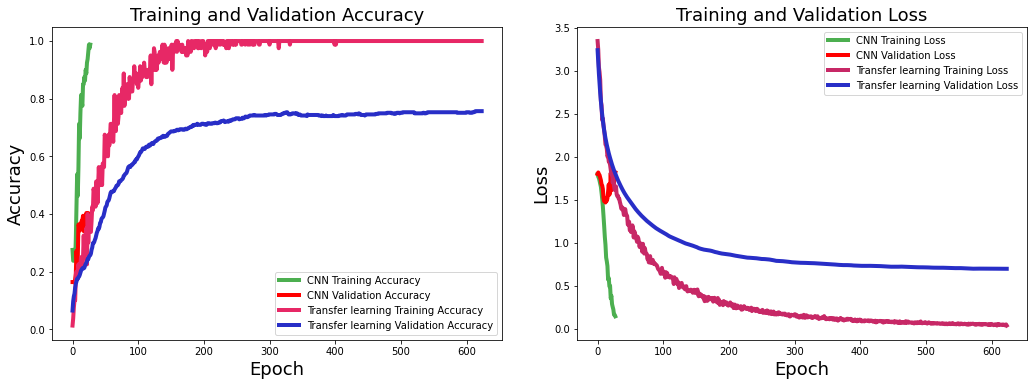

In [20]:
#TL 기반 모델을 학습 한 후 CNN 모델의 학습 성능을 TL 기반 모델과 비교 
#다음 코드 블록은 단순 CNN 및 TL 기반 모델의 에포크에 대한 훈련 정확도 및 손실 값을 보여줌
epochs_range = range(800)
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot( acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot( val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot( acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot( val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot( loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot( loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot( val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
plt.show()

In [21]:
#score
y_prob = model.predict(x_val) 
predictions = y_prob.argmax(axis=-1)
predictions = predictions.reshape(1,-1)[0]
#TL 기반 모델을 테스트하고 분류 성능 출력
print(classification_report(y_val, predictions, target_names = categories))

              precision    recall  f1-score   support

  된장찌개       0.68      0.60      0.64        86
   잡곡밥       0.89      0.82      0.85        89
   김치찌개       0.57      0.72      0.64        86
   배추김치       0.73      0.91      0.81        88
    미역국       0.88      0.65      0.75        89
    백김치       0.88      0.83      0.85        88

    accuracy                           0.76       526
   macro avg       0.77      0.76      0.76       526
weighted avg       0.77      0.76      0.76       526



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4460 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s

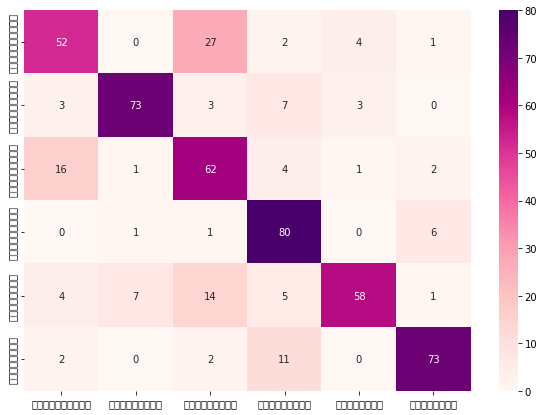

In [22]:
#confusion matrix
cm2 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm2, index = [i for i in categories],columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")